# Characterization of Alzheimer's Disease through clustering of Medical notes

## Introduction

### Importing packages

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datetime import datetime, date
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-l312fxi3 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Data Pre-processing

### Exploring the data

In [30]:
path = "data/Early-onset.csv"
df = pd.read_csv(path)
df

person_id       birth_datetime gender_source_value race_source_value  \
0            271  1932-02-09 00:00:00              FEMALE             WHITE   
1            271  1932-02-09 00:00:00              FEMALE             WHITE   
2            271  1932-02-09 00:00:00              FEMALE             WHITE   
3            271  1932-02-09 00:00:00              FEMALE             WHITE   
4            271  1932-02-09 00:00:00              FEMALE             WHITE   
...          ...                  ...                 ...               ...   
26182     258985  1946-12-18 00:00:00              FEMALE             WHITE   
26183     258985  1946-12-18 00:00:00              FEMALE             WHITE   
26184     258985  1946-12-18 00:00:00              FEMALE             WHITE   
26185     258985  1946-12-18 00:00:00              FEMALE             WHITE   
26186     258985  1946-12-18 00:00:00              FEMALE             WHITE   

      ethnicity_source_value                 note_title  \
0               NOT HISPANIC  order_impression: IMAGING   
1               NOT HISPANIC  order_impression: IMAGING   
2               NOT HISPANIC  order_impression: IMAGING   
3               NOT HISPANIC  order_impression: IMAGING   
4               NOT HISPANIC  order_impression: IMAGING   
...                      ...                        ...   
26182           NOT HISPANIC    order_narative: IMAGING   
26183           NOT HISPANIC    order_narative: IMAGING   
26184           NOT HISPANIC    order_narative: IMAGING   
26185           NOT HISPANIC    order_narative: IMAGING   
26186           NOT HISPANIC    order_narative: IMAGING   

                                               note_text  
0      No acute osseous abnormality of the right shou...  
1      FINDINGS OF PULMONARY EDEMA. ACUITY LEVEL: 2. ...  
2      No acute osseous abnormality of the right shou...  
3      No acute osseous abnormality of the right shou...  
4      1. Moderate subcutaneous hematoma about the le...  
...                                                  ...  
26182  X-ray abdomen complete with chest Indication: ...  
26183  CTA dissection protocol. Technique: Axial imag...  
26184  CTA dissection protocol. Technique: Axial imag...  
26185  Study: AP radiograph of the chest History: Wea...  
26186  CTA dissection protocol. Technique: Axial imag...  

[26187 rows x 7 columns]

### Calculating the age of each patient from their birth date

In [31]:
# Converting the "birth_datetime" column to a datetime format 
df["birth_datetime"] = pd.to_datetime(df["birth_datetime"], format='%Y-%m-%d')
# Calculating the age by substracting the current date with the date in the dataframe
df["age"] = (pd.Timestamp('now') - df["birth_datetime"]).astype('timedelta64[Y]')
# Converting age to integer
df["age"]  = pd.to_numeric(df["age"], downcast='integer')
# Dropping the birth_datetime (it's useless at this point) 
df = df.drop("birth_datetime", axis=1)
# Re-arranging the order of the columns
df = df[['person_id', 'age', 'gender_source_value', 'race_source_value', 'ethnicity_source_value', 'note_title', 'note_text']]
df

person_id  age gender_source_value race_source_value  \
0            271   90              FEMALE             WHITE   
1            271   90              FEMALE             WHITE   
2            271   90              FEMALE             WHITE   
3            271   90              FEMALE             WHITE   
4            271   90              FEMALE             WHITE   
...          ...  ...                 ...               ...   
26182     258985   75              FEMALE             WHITE   
26183     258985   75              FEMALE             WHITE   
26184     258985   75              FEMALE             WHITE   
26185     258985   75              FEMALE             WHITE   
26186     258985   75              FEMALE             WHITE   

      ethnicity_source_value                 note_title  \
0               NOT HISPANIC  order_impression: IMAGING   
1               NOT HISPANIC  order_impression: IMAGING   
2               NOT HISPANIC  order_impression: IMAGING   
3               NOT HISPANIC  order_impression: IMAGING   
4               NOT HISPANIC  order_impression: IMAGING   
...                      ...                        ...   
26182           NOT HISPANIC    order_narative: IMAGING   
26183           NOT HISPANIC    order_narative: IMAGING   
26184           NOT HISPANIC    order_narative: IMAGING   
26185           NOT HISPANIC    order_narative: IMAGING   
26186           NOT HISPANIC    order_narative: IMAGING   

                                               note_text  
0      No acute osseous abnormality of the right shou...  
1      FINDINGS OF PULMONARY EDEMA. ACUITY LEVEL: 2. ...  
2      No acute osseous abnormality of the right shou...  
3      No acute osseous abnormality of the right shou...  
4      1. Moderate subcutaneous hematoma about the le...  
...                                                  ...  
26182  X-ray abdomen complete with chest Indication: ...  
26183  CTA dissection protocol. Technique: Axial imag...  
26184  CTA dissection protocol. Technique: Axial imag...  
26185  Study: AP radiograph of the chest History: Wea...  
26186  CTA dissection protocol. Technique: Axial imag...  

[26187 rows x 7 columns]

### Creating the corpus from medical notes 

#### Using the note_text column for raw data

In [111]:
corpus_raw = list(df["note_text"])

#### Removing words that don't contain much meaning from our notes

In [113]:
words_to_remove = ["NAME:", "[**NAME**]", "EXAM DATE:", "[**DATE**]", "LOC:", "[**LOCATION_INSTITUTE**]", "[**LOCATION_STREET**]", "[**LOCATION_ZIP**]", "[**LOCATION_CITY**]", "[**CONTACT_PHONE**]", "[**LOCATION_OTHER**]", "MRN:", "[**ID**]", "DOB:", "** VERIFIED **", "ORDERING MD:", "ORDER:", "ORD. SERVICE:", "ORD. LOC:", "TECH", "RMS# / INV#:"]
corpus_clean = []
for item in corpus_raw:
    for word in words_to_remove:
        item = item.replace(word, '')
    corpus_clean.append(item)

#### Taking each word from the cleaned corpus and making it lowercase

In [137]:
corpus = [word.lower() for word in corpus_clean]
corpus

['no acute osseous abnormality of the right shoulder, right elbow, right forearm, or right humerus. acuity level: 1. routine: a normal examination or findings that are inconsequential.',
 'findings of pulmonary edema. acuity level: 2. non-routine: findings that are non-emergent, not unexpected, relatively minor,  already known, not significantly changed or are unlikely to result in significant short-term morbidity.',
 'no acute osseous abnormality of the right shoulder, right elbow, right forearm, or right humerus. acuity level: 1. routine: a normal examination or findings that are inconsequential.',
 'no acute osseous abnormality of the right shoulder, right elbow, right forearm, or right humerus. acuity level: 1. routine: a normal examination or findings that are inconsequential.',
 '1. moderate subcutaneous hematoma about the left high parietal bone, with no ct evidence of acute intracranial abnormality. if there is clinical concern for acute infarct, mri could be considered for fur

#### Adding the pre-processed version of the notes to the DataFrame

In [119]:
df["note_text"] = corpus
df

person_id  age gender_source_value race_source_value  \
0            271   90              FEMALE             WHITE   
1            271   90              FEMALE             WHITE   
2            271   90              FEMALE             WHITE   
3            271   90              FEMALE             WHITE   
4            271   90              FEMALE             WHITE   
...          ...  ...                 ...               ...   
26182     258985   75              FEMALE             WHITE   
26183     258985   75              FEMALE             WHITE   
26184     258985   75              FEMALE             WHITE   
26185     258985   75              FEMALE             WHITE   
26186     258985   75              FEMALE             WHITE   

      ethnicity_source_value                 note_title  \
0               NOT HISPANIC  order_impression: IMAGING   
1               NOT HISPANIC  order_impression: IMAGING   
2               NOT HISPANIC  order_impression: IMAGING   
3               NOT HISPANIC  order_impression: IMAGING   
4               NOT HISPANIC  order_impression: IMAGING   
...                      ...                        ...   
26182           NOT HISPANIC    order_narative: IMAGING   
26183           NOT HISPANIC    order_narative: IMAGING   
26184           NOT HISPANIC    order_narative: IMAGING   
26185           NOT HISPANIC    order_narative: IMAGING   
26186           NOT HISPANIC    order_narative: IMAGING   

                                               note_text  
0      no acute osseous abnormality of the right shou...  
1      findings of pulmonary edema. acuity level: 2. ...  
2      no acute osseous abnormality of the right shou...  
3      no acute osseous abnormality of the right shou...  
4      1. moderate subcutaneous hematoma about the le...  
...                                                  ...  
26182  x-ray abdomen complete with chest indication: ...  
26183  cta dissection protocol. technique: axial imag...  
26184  cta dissection protocol. technique: axial imag...  
26185  study: ap radiograph of the chest history: wea...  
26186  cta dissection protocol. technique: axial imag...  

[26187 rows x 7 columns]

## Creating Text embeddings

In [33]:
model = SentenceTransformer("../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT")

No sentence-transformers model found with name ../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at ../models/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

### Some model parameters

The Transformer itself has a max sequence length of 512 tokens and it does not lowercase the input. For the pooling operation we will produce a 768-dimensional sentence embedding. We do this using mean pooling 

In [34]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [120]:
embeddings = model.encode(corpus, show_progress_bar=True)

Batches:   0%|          | 0/819 [00:00<?, ?it/s]

In [121]:
embeddings

array([[-0.01031018, -0.30022824, -0.00404201, ...,  0.16678284,
        -0.06362958, -0.1038893 ],
       [ 0.24206904, -0.12554163, -0.11126483, ...,  0.13504244,
        -0.07171032, -0.21101828],
       [-0.01031018, -0.30022824, -0.00404201, ...,  0.16678284,
        -0.06362958, -0.1038893 ],
       ...,
       [ 0.1552543 , -0.25047046,  0.00982172, ...,  0.24153823,
        -0.13299753, -0.10478689],
       [-0.04440079, -0.36117136, -0.08876899, ...,  0.30786514,
        -0.02766546, -0.12980634],
       [ 0.1552543 , -0.25047046,  0.00982172, ...,  0.24153823,
        -0.13299753, -0.10478689]], dtype=float32)

In [122]:
embeddings.shape

(26187, 768)

## Clustering with K-means

In [123]:
num_clusters = 10
cluster = KMeans(n_clusters=num_clusters)
cluster.fit(embeddings)
cluster_assignment = cluster.labels_

### Taking a look at the different categories

In [124]:
cluster_assignment

array([5, 5, 5, ..., 8, 1, 8], dtype=int32)

### Putting the notes with their clusters for better visualization

In [125]:
df_corpus = pd.DataFrame({"person_id": df["person_id"], "Corpus": corpus, "Cluster": cluster_assignment})
df_corpus

person_id                                             Corpus  Cluster
0            271  no acute osseous abnormality of the right shou...        5
1            271  findings of pulmonary edema. acuity level: 2. ...        5
2            271  no acute osseous abnormality of the right shou...        5
3            271  no acute osseous abnormality of the right shou...        5
4            271  1. moderate subcutaneous hematoma about the le...        3
...          ...                                                ...      ...
26182     258985  x-ray abdomen complete with chest indication: ...        8
26183     258985  cta dissection protocol. technique: axial imag...        8
26184     258985  cta dissection protocol. technique: axial imag...        8
26185     258985  study: ap radiograph of the chest history: wea...        1
26186     258985  cta dissection protocol. technique: axial imag...        8

[26187 rows x 3 columns]

## Data Visualization

In [126]:
def word_cloud(pred_df,label):
    wc = ' '.join([text for text in df_corpus['Corpus'][df_corpus['Cluster'] == label]])
    wordcloud = WordCloud(width=800, height=500,
    random_state=21, max_font_size=110).generate(wc)
    fig7 = plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

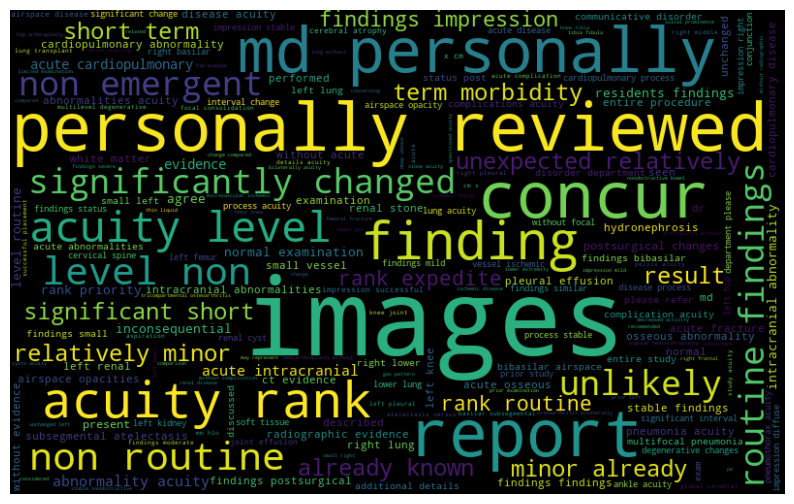

In [127]:
word_cloud(df_corpus,0)

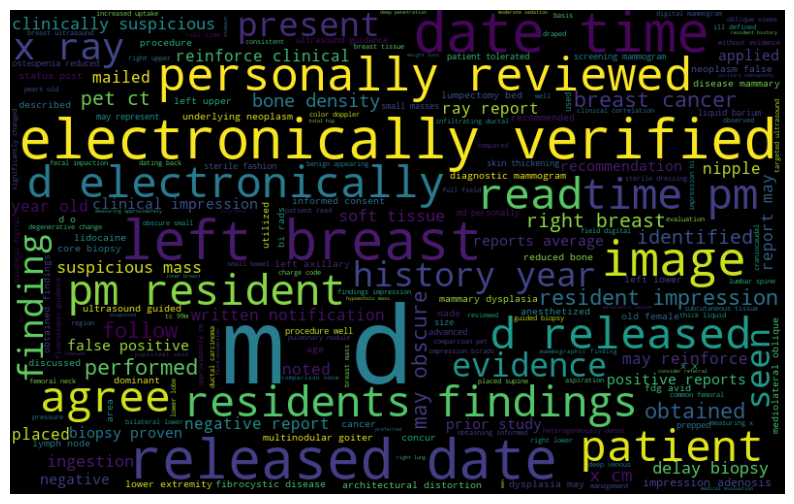

In [128]:
word_cloud(df_corpus,1)

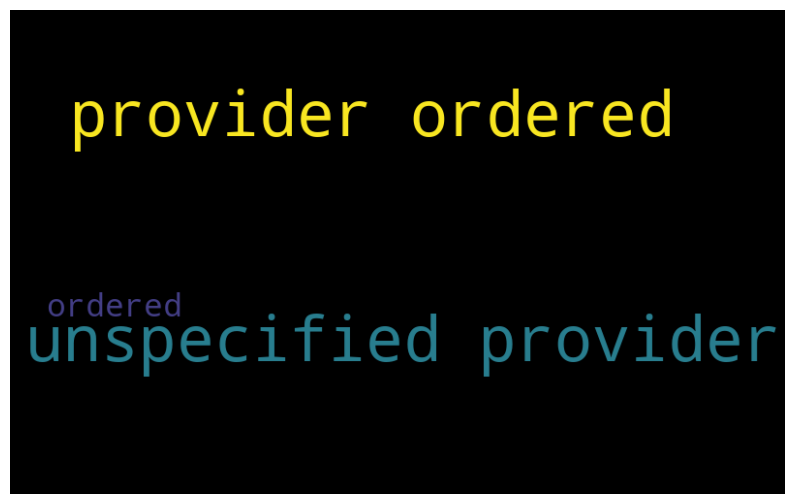

In [129]:
word_cloud(df_corpus,2)

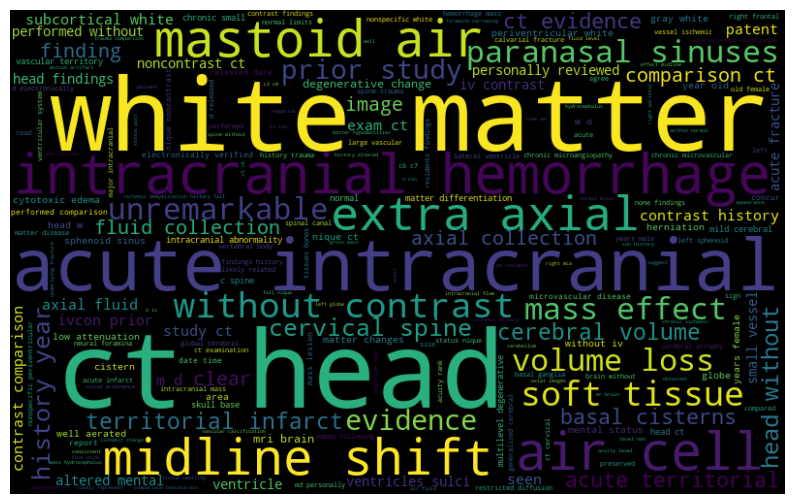

In [130]:
word_cloud(df_corpus,3)

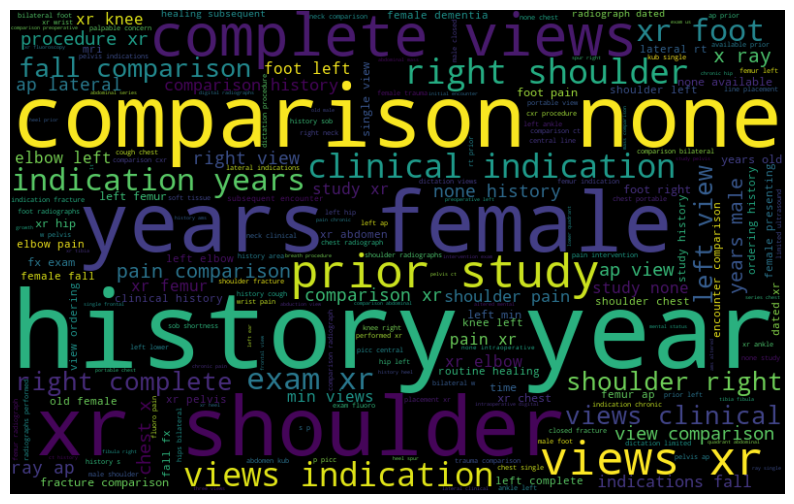

In [131]:
word_cloud(df_corpus,4)

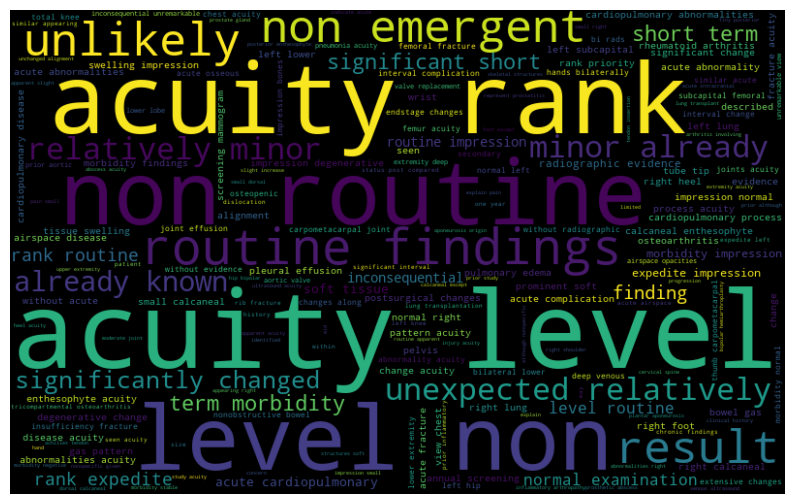

In [132]:
word_cloud(df_corpus,5)

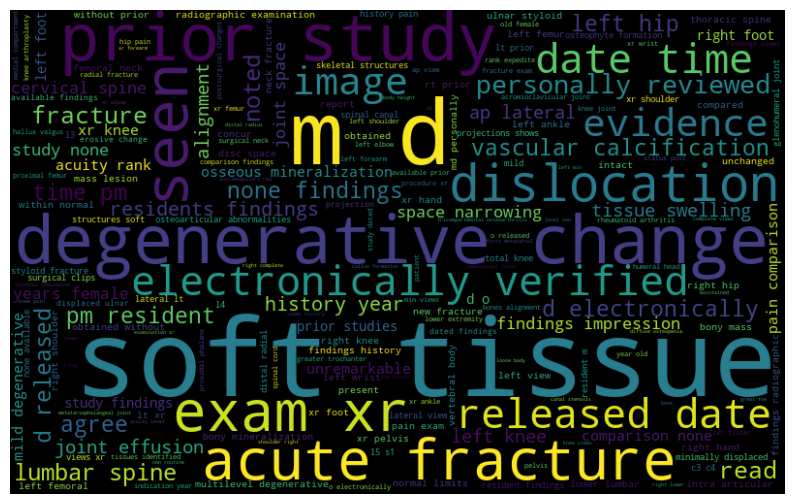

In [133]:
word_cloud(df_corpus,6)

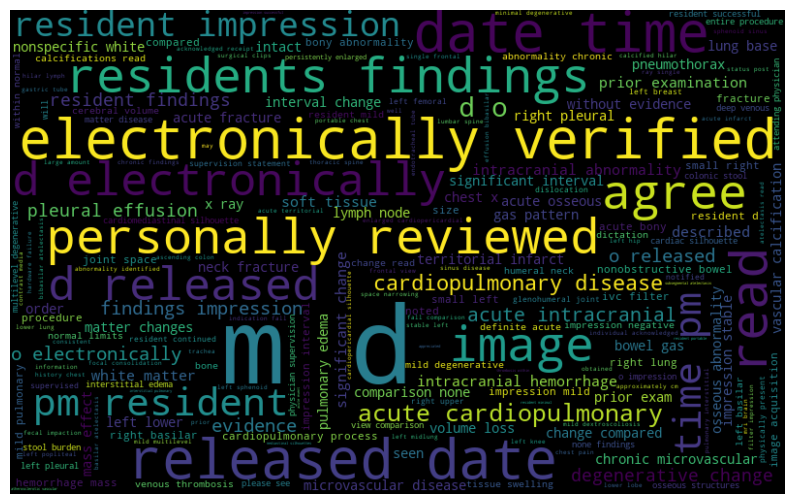

In [134]:
word_cloud(df_corpus,7)

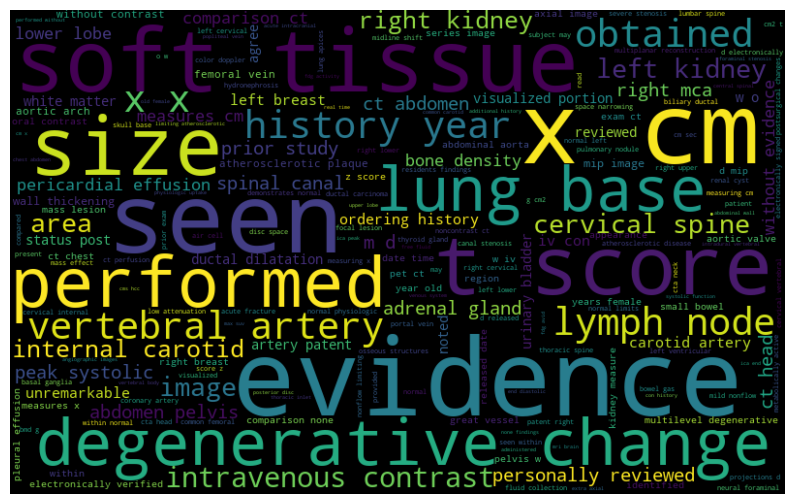

In [135]:
word_cloud(df_corpus,8)

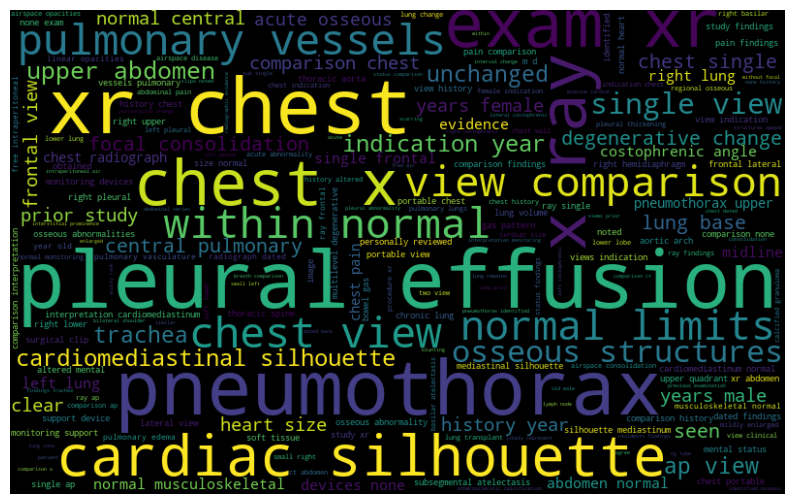

In [136]:
word_cloud(df_corpus,9)